# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2025**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.18.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `europe-west2` as it is closest to us geographically.
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-coursework-457710'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'europe-west2'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = europe-west2
[core]
account = Mayuri.Fokmare@city.ac.uk
project = big-data-coursework-457710
[dataproc]
region = europe-west2

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-coursework-457710-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-coursework-457710-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
3.5.0
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

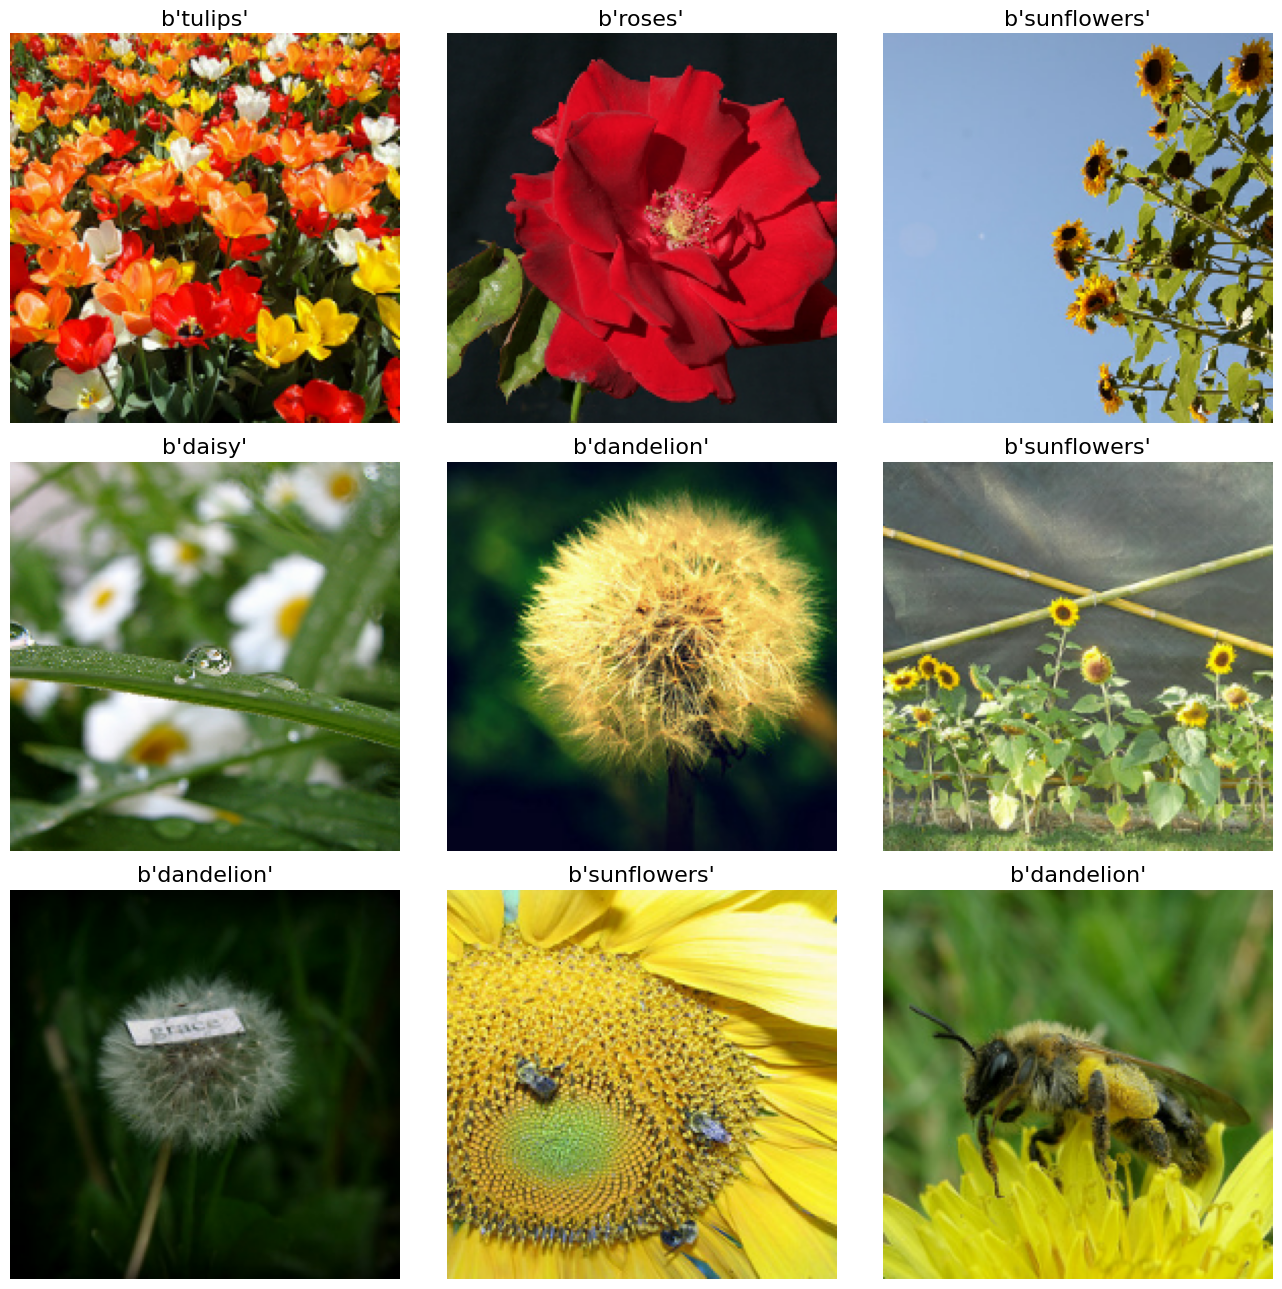

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['tulips', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'roses', 'roses', 'sunflowers', 'daisy'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'tulips', 'roses', 'sunflowers', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'roses', 'tulips', 'sunflowers', 'daisy', 'tulips', 'tulips', 'roses', 'sunflowers', 'roses'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'sunflowers', 'tulips', 'daisy', 'tulips', 'tulips', 'roses', 'roses', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'daisy', 'dandelion', 'dandelion', 'roses', 'daisy', 'sunflowers', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'tulips', 'daisy', 'daisy',

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['tulips', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'roses', 'daisy', 'sunflowers', 'dandelion', 'roses'])
Image batch shape (10,), ['sunflowers', 'roses', 'tulips', 'roses', 'sunflowers', 'tulips', 'tulips', 'daisy', 'daisy', 'dandelion'])
Image batch shape (10,), ['tulips', 'sunflowers', 'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion', 'dandelion', 'roses', 'roses'])
Image batch shape (10,), ['daisy', 'tulips', 'sunflowers', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'daisy', 'daisy', 'sunflowers'])
Image batch shape (10,), ['dandelion', 'tulips', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion'])
Image batch shape (10,), ['dandelion', 'tulips', 'dandelion', 'dandelion', 'roses', 'roses', 'sunflowers', 'dandelion', 'roses', 'dandelion'])
Image batch shape (10,), ['tulips', 'daisy', 'tulips', 'tulips', 'sunflowers', 'roses', 'roses', 'dandelion', 'roses', 'sunflowers'])
Image batch shape (10

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

#  write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '0', '3', '4', '2', '2', '3', '2', '0', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '3', '2', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['1', '3', '4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '2', '0', '0', '1', '4', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '0', '2', '3', '4', '2', '1', '1', '0'])
Image batch shape (10, 192, 192, 3), ['0', '1', '1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '1', '1', '1', '0', '1', '4', '3', '2'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
# Google Cloud Storage bucket path
GCS_OUTPUT = 'gs://big-data-coursework-457710-storage/tfrecords-spark/'

# Sampling factor for testing using 2% of data to test faster
SAMPLE_FRACTION = 0.02

# copied and adapted mapping Functions from section 1.1
# Function to resize and crop the image to the target size
# Adapted to take a (image, label) tuple input for Spark RDD
def resize_and_crop_image_spark(image_label_tuple):
    image, label = image_label_tuple
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    # criterion to decide resizing dimensions
    resize_crit = (w * th) / (h * tw)

    # Resize while preserving aspect ratio and ensuring no black bars
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w * tw / w, h * tw / w]),
                    lambda: tf.image.resize(image, [w * th / h, h * th / h]))

    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]

    # Crop the center to exactly match TARGET_SIZE
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

# Function to recompress the image back into JPEG format
def recompress_image_spark(image_label_tuple):
    image, label = image_label_tuple
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    image = image.numpy()
    return image, label

# Helper functions to create TFRecord Features
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

# List all file paths matching the pattern
filenames = tf.io.gfile.glob(GCS_PATTERN)

# Parallelize the filenames list into a Spark RDD
filenames_rdd = sc.parallelize(filenames)
sampled_filenames_rdd = filenames_rdd.sample(False, SAMPLE_FRACTION)

# Decode, Resize, Recompress using Spark map function
# Decode JPEG images and extract labels
decoded_rdd = sampled_filenames_rdd.map(lambda filepath: decode_jpeg_and_label(filepath))

# Resize and crop images to target size
resized_rdd = decoded_rdd.map(resize_and_crop_image_spark)

# Recompress resized images into optimized JPEGs
recompressed_rdd = resized_rdd.map(recompress_image_spark)

# Write TFRecord Files (One File Per Partition)
# Function that writes one TFRecord file for each RDD partition
def write_partition(partition_idx, iterator):
    output_path = GCS_OUTPUT + f"partition-{partition_idx:02d}.tfrec"
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_tensor, label_tensor in iterator:
            example = to_tfrecord(writer, img_tensor, label_tensor)
            writer.write(example.SerializeToString())
    yield output_path

# Apply the write_partition function across all partitions using mapPartitionsWithIndex
output_files = recompressed_rdd.mapPartitionsWithIndex(write_partition).collect()

# Print created TFRecord filenames
print("TFRecord files created:")
for f in output_files:
    print(f)

TFRecord files created:
gs://big-data-coursework-457710-storage/tfrecords-spark/partition-00.tfrec
gs://big-data-coursework-457710-storage/tfrecords-spark/partition-01.tfrec


### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


Found 32 files.


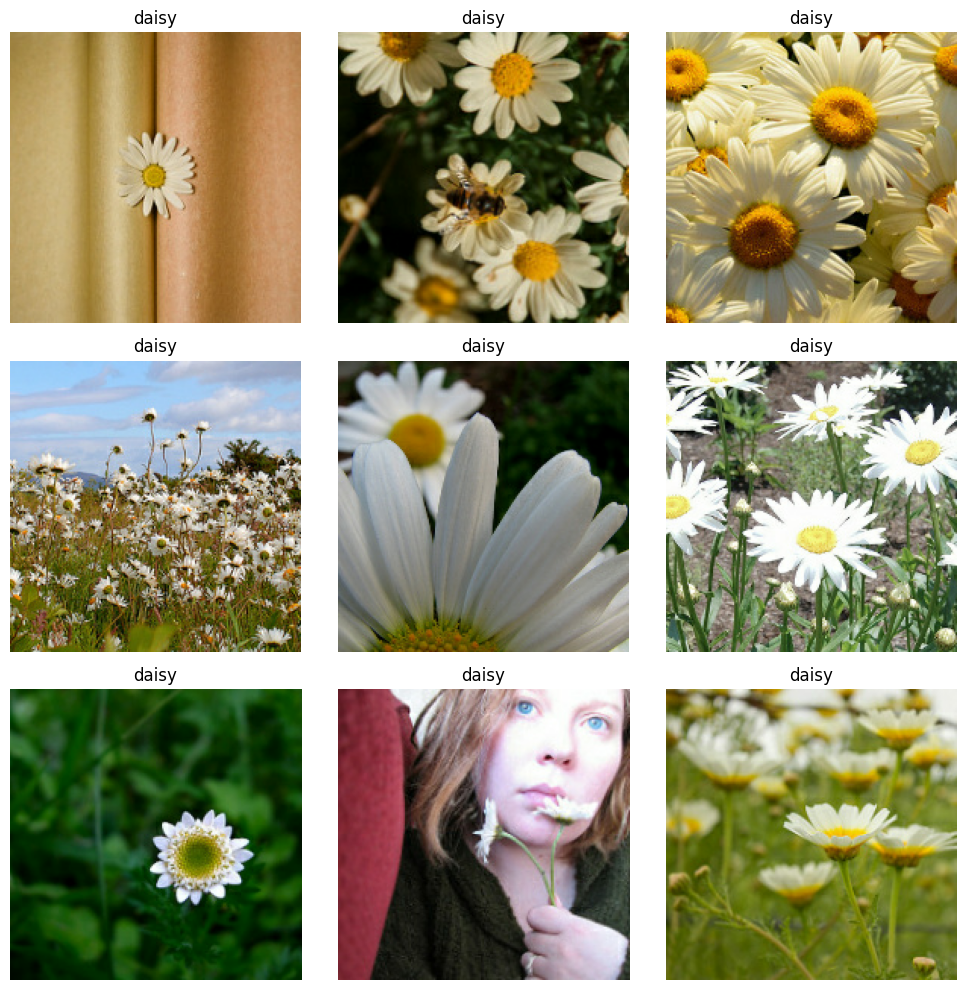

In [ ]:
# List TFRecord files which wrote earlier
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
print(f"Found {len(filenames)} files.")

# Load the dataset using above predefined function
dataset_tfrec = load_dataset(filenames)

# Display 9 sample images using above predefined function
display_9_images_from_dataset(dataset_tfrec)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%%writefile spark_write_tfrec.py

import tensorflow as tf
import time
from pyspark import SparkContext

# CONFIGURATION
TARGET_SIZE = (192, 192)
SAMPLE_FRACTION = 0.02
GCS_PATTERN = 'gs://big-data-coursework-457710-storage/images/**/*.jpg'
GCS_OUTPUT = 'gs://big-data-coursework-457710-storage/tfrecords-spark/'

# TFRecord Helpers
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(writer, image_bytes, label):
    feature = {
        'image': _bytestring_feature([image_bytes]),
        'label': _int_feature([label])
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

# Image Functions
def decode_jpeg_and_label(filepath):
    image = tf.io.decode_jpeg(tf.io.read_file(filepath))
    label = int(filepath.split('/')[-2])
    return image, label

def resize_and_crop_image_spark(image_label_tuple):
    image, label = image_label_tuple
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw, th = TARGET_SIZE[1], TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)

    image = tf.cond(
        resize_crit < 1,
        lambda: tf.image.resize(image, [w * tw / w, h * tw / w]),
        lambda: tf.image.resize(image, [w * th / h, h * th / h])
    )

    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image_spark(image_label_tuple):
    image, label = image_label_tuple
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    image = image.numpy()
    return image, label

# TFRecord Writing Per Partition
def write_partition(partition_idx, iterator):
    output_path = GCS_OUTPUT + f"partition-{partition_idx:02d}.tfrec"
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_tensor, label_tensor in iterator:
            example = to_tfrecord(writer, img_tensor, label_tensor)
            writer.write(example.SerializeToString())
    yield output_path

# Start timer
start = time.time()

# Initialize Spark
sc = SparkContext.getOrCreate()

# Gather filepaths from GCS
filenames = tf.io.gfile.glob(GCS_PATTERN)

# Create Spark RDD pipeline
filenames_rdd = sc.parallelize(filenames)
sampled_rdd = filenames_rdd.sample(False, SAMPLE_FRACTION)
decoded_rdd = sampled_rdd.map(decode_jpeg_and_label)
resized_rdd = decoded_rdd.map(resize_and_crop_image_spark)
recompressed_rdd = resized_rdd.map(recompress_image_spark)
output_files = recompressed_rdd.mapPartitionsWithIndex(write_partition).collect()

# Display output files
print("TFRecord files created:")
for f in output_files:
    print(f)

# End timer
end = time.time()
time.sleep(2)
print(f"Total time: {end - start:.2f} seconds")

# Stop Spark
sc.stop()

Writing spark_write_tfrec.py


In [ ]:
!python3 spark_write_tfrec.py

2025-05-02 02:16:35.196252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746152195.234821   10380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746152195.245960   10380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/02 02:16:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/02 02:16:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2025-05-02 02:16:56.581780: E external/local_xla/xla/stream_execu

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
!gcloud dataproc clusters create $CLUSTER \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --metadata=PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.20.* scipy matplotlib numpy pyspark" \
    --enable-component-gateway \
    --single-node

Waiting on operation [projects/big-data-coursework-457710/regions/europe-west2/operations/eda5ec40-6e9c-334c-8d1d-059d618dc544].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-457710/regions/europe-west2/clusters/big-data-coursework-457710-cluster] Cluster placed in zone [europe-west2-c].


Run the script in the cloud and test the output.

In [ ]:
# copy script into bucket
!gsutil cp spark_write_tfrec.py gs://{PROJECT}-storage/scripts/

Copying file://spark_write_tfrec.py [Content-Type=text/x-python]...
/ [1 files][  3.3 KiB/  3.3 KiB]                                                
Operation completed over 1 objects/3.3 KiB.                                      


In [ ]:
#executing the script into cloud
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_write_tfrec.py \
    --cluster=big-data-coursework-457710-cluster \
    --region=europe-west2

Job [8eed8a9ea32749ff8120935490182c67] submitted.
Waiting for job output...
2025-04-30 18:09:09.583332: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 18:09:09.583371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 18:09:12 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 18:09:12 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 18:09:12 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 18:09:13 INFO org.spark_project.jetty.util.log: Logging initialized @5443ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 18:09:13 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
# Define a new cluster name for maximal cluster
CLUSTER_MAXIMAL = f"{PROJECT}-maximal-cluster"

# Create the maximal cluster (1 master + 7 workers)
!gcloud dataproc clusters create $CLUSTER_MAXIMAL \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --worker-machine-type=n1-standard-1 \
    --num-workers=7 \
    --worker-boot-disk-type=pd-standard \
    --worker-boot-disk-size=100 \
    --metadata=PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.20.* scipy matplotlib numpy pyspark" \
    --region=$REGION

Waiting on operation [projects/big-data-coursework-457710/regions/europe-west2/operations/2d00aec6-ff8b-330b-8ecb-f29f3b17dc6e].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-457710/regions/europe-west2/clusters/big-data-coursework-457710-maximal-cluster] Cluster placed in zone [europe-west2-c].


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_write_tfrec.py \
    --cluster=big-data-coursework-457710-maximal-cluster \
    --region=europe-west2

Job [807d811b0f5c4310bab93bad68390bc6] submitted.
Waiting for job output...
2025-05-02 02:25:19.535032: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-02 02:25:19.535199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/02 02:25:25 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/02 02:25:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/02 02:25:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/02 02:25:25 INFO org.spark_project.jetty.util.log: Logging initialized @10695ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/02 02:25:26 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
%%writefile spark_task1_d_improve_parallelisation.py

import tensorflow as tf
import time
from pyspark import SparkContext

# CONFIGURATION
GCS_PATTERN = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/*/*.jpg'
GCS_OUTPUT = 'gs://big-data-coursework-457710-storage/tfrecords-spark/'
TARGET_SIZE = (192, 192)
### TASK 1d ###
PARTITIONS = 16
SAMPLE_FRACTION = 0.02
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# TFRecord Helpers
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(writer, image_bytes, label):
    feature = {
        'image': _bytestring_feature([image_bytes]),
        'label': _int_feature([label])
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

# Image Functions
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits, channels=3)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2]
    return image, label

def resize_and_crop_image_spark(image_label_tuple):
    image, label = image_label_tuple
    image = tf.image.resize_with_pad(image, TARGET_SIZE[0], TARGET_SIZE[1])
    return image, label

def recompress_image_spark(image_label_tuple):
    image, label = image_label_tuple
    image = tf.cast(image, tf.uint8)
    image_bytes = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False).numpy()
    label_str = label.numpy().decode('utf-8')
    label_index = CLASSES.index(label_str.encode())
    return image_bytes, label_index

# TFRecord Writing Per Partition
def write_partition(partition_idx, iterator):
    output_path = GCS_OUTPUT + f"partition-{partition_idx:02d}.tfrec"
    with tf.io.TFRecordWriter(output_path) as writer:
        for image_bytes, label_index in iterator:
            example = to_tfrecord(writer, image_bytes, label_index)
            writer.write(example.SerializeToString())
    yield output_path

# Start timer
start = time.time()

# Initialize Spark
sc = SparkContext.getOrCreate()

# Gather filepaths from GCS and sample
filenames = tf.io.gfile.glob(GCS_PATTERN)
### TASK 1d ###
filenames_rdd = sc.parallelize(filenames, PARTITIONS)
sampled_rdd = filenames_rdd.sample(False, SAMPLE_FRACTION)

# Spark data pipeline
decoded_rdd = sampled_rdd.map(decode_jpeg_and_label)
resized_rdd = decoded_rdd.map(resize_and_crop_image_spark)
recompressed_rdd = resized_rdd.map(recompress_image_spark)
output_files = recompressed_rdd.mapPartitionsWithIndex(write_partition).collect()

# Display output files
print("TFRecord files created:")
for f in output_files:
    print(f)

# End timer
end = time.time()
time.sleep(2)
print(f"Total time: {end - start:.2f} seconds")

# Stop Spark
sc.stop()

Overwriting spark_task1_d_improve_parallelisation.py


In [ ]:
!python3 spark_task1_d_improve_parallelisation.py

2025-04-30 19:46:13.816989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746042373.855362   44601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746042373.868088   44601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/30 19:46:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/30 19:46:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2025-04-30 19:46:31.884017: E external/local_xla/xla/stream_execu

In [ ]:
!gsutil cp spark_task1_d_improve_parallelisation.py gs://{PROJECT}-storage/scripts/

Copying file://spark_task1_d_improve_parallelisation.py [Content-Type=text/x-python]...
/ [1 files][  3.2 KiB/  3.2 KiB]                                                
Operation completed over 1 objects/3.2 KiB.                                      


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_task1_d_improve_parallelisation.py \
    --cluster=big-data-coursework-457710-maximal-cluster \
    --region=europe-west2

Job [81e47b735e3b42a98011444962f6c19d] submitted.
Waiting for job output...
2025-05-02 03:33:34.741411: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-02 03:33:34.741567: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/02 03:33:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/02 03:33:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/02 03:33:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/02 03:33:38 INFO org.spark_project.jetty.util.log: Logging initialized @7045ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/02 03:33:38 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
#1d-ii
# Define cluster name for 4 VMs (each 2 vCPUs)
CLUSTER_4VM = f"{PROJECT}-4vm-cluster"

# Create the 4-node cluster (1 master + 3 workers)
!gcloud dataproc clusters create $CLUSTER_4VM \
    --region=$REGION \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --master-machine-type=n1-standard-2 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --worker-machine-type=n1-standard-2 \
    --num-workers=3 \
    --worker-boot-disk-type=pd-standard \
    --worker-boot-disk-size=100 \
    --metadata=PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.20.* scipy matplotlib numpy pyspark" \
    --enable-component-gateway

Waiting on operation [projects/big-data-coursework-457710/regions/europe-west2/operations/e0a8725d-bfc0-3551-88e1-dd474b78c0e7].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-457710/regions/europe-west2/clusters/big-data-coursework-457710-4vm-cluster] Cluster placed in zone [europe-west2-c].


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_write_tfrec.py \
    --cluster=big-data-coursework-457710-4vm-cluster \
    --region=europe-west2

Job [f9761b52aa2e40c6b7d474a72153465f] submitted.
Waiting for job output...
2025-04-30 22:30:58.059306: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 22:30:58.059349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 22:31:02 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 22:31:02 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 22:31:02 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 22:31:02 INFO org.spark_project.jetty.util.log: Logging initialized @8142ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 22:31:03 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_task1_d_improve_parallelisation.py \
    --cluster=big-data-coursework-457710-4vm-cluster \
    --region=europe-west2

Job [985b84db66b44f199ce1c90f2cbcf385] submitted.
Waiting for job output...
2025-04-30 22:32:14.611672: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 22:32:14.611711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 22:32:17 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 22:32:17 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 22:32:17 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 22:32:17 INFO org.spark_project.jetty.util.log: Logging initialized @5598ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 22:32:17 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
# Define cluster name for 1 big VM
CLUSTER_1BIGVM = f"{PROJECT}-1bigvm-cluster"

# Create the 1-node large cluster
!gcloud dataproc clusters create $CLUSTER_1BIGVM \
    --region=$REGION \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --single-node \
    --metadata=PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.20.* scipy matplotlib numpy pyspark" \
    --enable-component-gateway

Waiting on operation [projects/big-data-coursework-457710/regions/europe-west2/operations/b5969dd5-209d-38ad-898a-72a026a243c4].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-457710/regions/europe-west2/clusters/big-data-coursework-457710-1bigvm-cluster] Cluster placed in zone [europe-west2-c].


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_write_tfrec.py \
    --cluster=big-data-coursework-457710-1bigvm-cluster \
    --region=europe-west2

Job [8929bcd1a5e745c788bfd3928461bc4e] submitted.
Waiting for job output...
2025-04-30 21:50:26.139177: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 21:50:26.139224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 21:50:29 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 21:50:29 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 21:50:29 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 21:50:29 INFO org.spark_project.jetty.util.log: Logging initialized @5306ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 21:50:29 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_task1_d_improve_parallelisation.py \
    --cluster=big-data-coursework-457710-1bigvm-cluster \
    --region=europe-west2

Job [80e6daaf17bc459186f6e5c565bda9f5] submitted.
Waiting for job output...
2025-04-30 22:09:02.816393: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-04-30 22:09:02.816432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/04/30 22:09:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/04/30 22:09:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/04/30 22:09:05 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/04/30 22:09:05 INFO org.spark_project.jetty.util.log: Logging initialized @4182ms to org.spark_project.jetty.util.log.Slf4jLog
25/04/30 22:09:05 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'sunflowers'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'sunflowers'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'roses'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image batch shape (2,), ["b'dandelion'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='utf-8'>
Image bat

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
%%writefile spark_job.py

import os
import sys
import math
import numpy as np
import tensorflow as tf
import pickle
from pyspark import SparkContext
import time

# Configuration
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

batch_sizes = [2, 4]
batch_numbers = [3, 6]
repetitions = [1]
pickle_output_path = 'gs://big-data-coursework-457710-storage/results/speedtest_results.pkl'

# Dataset
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# Timing function for each config
def time_one_config(config):
    batch_size, batch_number, repetition = config

    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    dataset = dataset.batch(batch_size)
    timing_set = dataset.take(batch_number)

    images_read = batch_size * batch_number

    total_time = 0
    for _ in range(repetition):
        t0 = time.time()
        for image_batch, label_batch in timing_set:
            _ = image_batch.numpy()
            _ = label_batch.numpy()
        td = time.time() - t0
        total_time += td

    images_per_sec = images_read * repetition / total_time
    return ((batch_size, batch_number), images_per_sec)

# Main Spark job
if __name__ == "__main__":
    sc = SparkContext()

    # Create list of parameter combinations
    param_list = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]

    # Parallelize parameter combinations
    param_rdd = sc.parallelize(param_list)

    # Run timing test in parallel
    result_rdd = param_rdd.map(time_one_config)

    # Group by (batch_size, batch_number)
    grouped_rdd = result_rdd.groupByKey()

    # Compute average throughput
    avg_rdd = grouped_rdd.mapValues(lambda v: sum(v) / len(v))

    # Collect results
    raw_results = result_rdd.collect()
    avg_results = avg_rdd.collect()

    # Save results to GCS as pickle
    save_object = {
        "raw_results": raw_results,
        "avg_results": avg_results
    }

    with tf.io.gfile.GFile(pickle_output_path, 'wb') as f:
        pickle.dump(save_object, f)

    print("Results saved to:", pickle_output_path)

    sc.stop()

Writing spark_job.py


In [ ]:
!gsutil cp spark_job.py gs://{PROJECT}-storage/scripts/

Copying file://spark_job.py [Content-Type=text/x-python]...
-
Operation completed over 1 objects/3.0 KiB.                                      


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_job.py \
    --cluster=big-data-coursework-457710-cluster \
    --region=europe-west2

Job [aff5562f5e10439ab9786e1045814be2] submitted.
Waiting for job output...
2025-05-01 11:48:18.213555: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-01 11:48:18.213596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/01 11:48:21 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/01 11:48:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/01 11:48:21 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/01 11:48:21 INFO org.spark_project.jetty.util.log: Logging initialized @5336ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/01 11:48:21 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
%%writefile spark_job_2b-i.py

import os
import sys
import math
import argparse
import numpy as np
import tensorflow as tf
import pickle
import time
from datetime import datetime
from pyspark import SparkContext

# Configuration Section
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'

# Image size (as in dataset)
TARGET_SIZE = [192, 192]

# Class label mappings (in byte format as used in TFRecord)
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# Parameters for timing tests
# number of images per batch
batch_sizes = [2, 4]
# number of batches to process
batch_numbers = [3, 6]
# number of times to repeat each test
repetitions = [1]

# TFRecord Parser Functions
# Parse a single TFRecord entry into image and label tensors
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

# Load the entire dataset as a tf.data.Dataset
def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False  # improves performance
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# Timing Function
# Measure images/sec for a specific (batch_size, batch_number, repetition)
def time_one_config(config):
    batch_size, batch_number, repetition = config

    # Load dataset from GCS
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    dataset = dataset.batch(batch_size)
    timing_set = dataset.take(batch_number)

    images_read = batch_size * batch_number
    total_time = 0

    # Repeat the test to average timing
    for _ in range(repetition):
        t0 = time.time()
        for image_batch, label_batch in timing_set:
            _ = image_batch.numpy()
            _ = label_batch.numpy()
        td = time.time() - t0
        total_time += td

    # Return throughput = images / total_time
    images_per_sec = images_read * repetition / total_time
    return ((batch_size, batch_number), images_per_sec)

# Main Spark Job Logic
if __name__ == "__main__":
    # Accept timestamp as CLI arg (used in output file name)
    parser = argparse.ArgumentParser()
    parser.add_argument("--timestamp", type=str, default=datetime.now().strftime("%y%m%d-%H%M"))
    args = parser.parse_args()

    # Compose output file name using timestamp
    pickle_output_path = f'gs://big-data-coursework-457710-storage/results/speedtest_results_{args.timestamp}.pkl'

    # Create Spark context
    sc = SparkContext.getOrCreate()

    # Prepare all parameter combinations
    param_list = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]

    # Parallelize parameter combinations to run in cloud in parallel
    param_rdd = sc.parallelize(param_list)

    # Run the timing function on each config
    result_rdd = param_rdd.map(time_one_config)

    # Group by (batch_size, batch_number) to compute avg over repetitions
    grouped_rdd = result_rdd.groupByKey()

    # Compute average images/sec
    avg_rdd = grouped_rdd.mapValues(lambda v: sum(v) / len(v))

    # Collect raw and avg results
    raw_results = result_rdd.collect()
    avg_results = avg_rdd.collect()

    # Save both sets of results to pickle file in GCS bucket
    save_object = {
        "raw_results": raw_results,
        "avg_results": avg_results
    }

    with tf.io.gfile.GFile(pickle_output_path, 'wb') as f:
        pickle.dump(save_object, f)

    print("Results saved to:", pickle_output_path)

    # Stop Spark
    sc.stop()

Overwriting spark_job_2b-i.py


In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
%run spark_job_2b-i.py --timestamp $timestamp

Results saved to: gs://big-data-coursework-457710-storage/results/speedtest_results_250501-1207.pkl


In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
%run spark_job_2b-i.py --timestamp $timestamp

Results saved to: gs://big-data-coursework-457710-storage/results/speedtest_results_250501-1208.pkl


In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
%run spark_job_2b-i.py --timestamp $timestamp

Results saved to: gs://big-data-coursework-457710-storage/results/speedtest_results_250501-1209.pkl


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
!gsutil cp spark_job_2b-i.py gs://{PROJECT}-storage/scripts/

Copying file://spark_job_2b-i.py [Content-Type=text/x-python]...
/ [1 files][  4.2 KiB/  4.2 KiB]                                                
Operation completed over 1 objects/4.2 KiB.                                      


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_job_2b-i.py \
    --cluster=big-data-coursework-457710-cluster \
    --region=europe-west2

Job [6606cef6de2441efb780b5b707e76df6] submitted.
Waiting for job output...
2025-05-01 12:13:40.860889: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-01 12:13:40.860933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/01 12:13:43 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/01 12:13:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/01 12:13:43 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/01 12:13:43 INFO org.spark_project.jetty.util.log: Logging initialized @4539ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/01 12:13:43 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [ ]:
%%writefile spark_job_2c_with_cache.py

import os
import sys
import math
import numpy as np
import tensorflow as tf
import pickle
from pyspark import SparkContext
import time
import argparse
import datetime

# Configuration variables
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

batch_sizes = [2, 4]
batch_numbers = [3, 6]
repetitions = [1]

# Dataset loading
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# Timing function for each config
def time_one_config(config):
    batch_size, batch_number, repetition = config

    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    dataset = dataset.batch(batch_size)
    timing_set = dataset.take(batch_number)

    images_read = batch_size * batch_number

    total_time = 0
    for _ in range(repetition):
        t0 = time.time()
        for image_batch, label_batch in timing_set:
            _ = image_batch.numpy()
            _ = label_batch.numpy()
        td = time.time() - t0
        total_time += td

    images_per_sec = images_read * repetition / total_time
    return ((batch_size, batch_number), images_per_sec)

# Main Spark job
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--timestamp', type=str, default=datetime.datetime.now().strftime("%y%m%d-%H%M"))
    args = parser.parse_args()

    # Unique filename using timestamp
    pickle_output_path = f'gs://big-data-coursework-457710-storage/results/speedtest_results_{args.timestamp}.pkl'

    sc = SparkContext()

    # Create list of parameter combinations
    param_list = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]
    param_rdd = sc.parallelize(param_list)

    # ----------------------
    # TASK 2c: Improve efficiency with .cache()
    # ----------------------
    t_start = time.time()

    ### TASK 2c ###
    # Caching RDD to avoid recomputation
    result_rdd = param_rdd.map(time_one_config).cache()

    # Force evaluation once to persist
    # triggers the cache
    result_rdd.count()

    # Collect raw results
    raw_results = result_rdd.collect()

    # Compute average by parameter key
    grouped_rdd = result_rdd.groupByKey()
    avg_rdd = grouped_rdd.mapValues(lambda v: sum(v) / len(v))
    avg_results = avg_rdd.collect()

    t_end = time.time()

    # Save to pickle
    save_object = {
        "raw_results": raw_results,
        "avg_results": avg_results,
        # Time measurement for caching benefit
        "execution_time_sec": t_end - t_start
    }

    with tf.io.gfile.GFile(pickle_output_path, 'wb') as f:
        pickle.dump(save_object, f)

    print(f"Results saved to: {pickle_output_path}")
    print(f"Total execution time: {t_end - t_start:.2f} seconds")

    sc.stop()

Writing spark_job_2c_with_cache.py


In [ ]:
!gsutil cp spark_job_2c_with_cache.py gs://{PROJECT}-storage/scripts/

Copying file://spark_job_2c_with_cache.py [Content-Type=text/x-python]...
-
Operation completed over 1 objects/3.6 KiB.                                      


In [ ]:
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_job_2c_with_cache.py \
    --cluster=big-data-coursework-457710-cluster \
    --region=europe-west2

Job [649b54744bb24b23876a8ab8bf9c75c4] submitted.
Waiting for job output...
2025-05-01 12:44:36.142785: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-01 12:44:36.142826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/01 12:44:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/01 12:44:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/01 12:44:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/01 12:44:38 INFO org.spark_project.jetty.util.log: Logging initialized @4496ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/01 12:44:38 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
%%writefile spark_job_without_cache.py

import os
import sys
import math
import numpy as np
import tensorflow as tf
import pickle
from pyspark import SparkContext
import time

# Configuration variables
GCS_OUTPUT = 'gs://cloud-samples-data/ai-platform/flowers_tfrec/tfrecords-jpeg-192x192-2/'
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

batch_sizes = [2, 4]
batch_numbers = [3, 6]
repetitions = [1]
pickle_output_path = 'gs://big-data-coursework-457710-storage/results/speedtest_results_no_cache.pkl'

# Dataset loading
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# Timing function for each config
def time_one_config(config):
    batch_size, batch_number, repetition = config

    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    dataset = load_dataset(filenames)
    dataset = dataset.batch(batch_size)
    timing_set = dataset.take(batch_number)

    images_read = batch_size * batch_number

    total_time = 0
    for _ in range(repetition):
        t0 = time.time()
        for image_batch, label_batch in timing_set:
            _ = image_batch.numpy()
            _ = label_batch.numpy()
        td = time.time() - t0
        total_time += td

    images_per_sec = images_read * repetition / total_time
    return ((batch_size, batch_number), images_per_sec)

# Main Spark job
if __name__ == "__main__":
    sc = SparkContext()

    # Start timing
    t_start = time.time()

    # Create list of parameter combinations
    param_list = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]

    # Parallelize parameter combinations
    param_rdd = sc.parallelize(param_list)

    # Run timing test in parallel (no caching)
    result_rdd = param_rdd.map(time_one_config)

    # Group by (batch_size, batch_number)
    grouped_rdd = result_rdd.groupByKey()

    # Compute average throughput
    avg_rdd = grouped_rdd.mapValues(lambda v: sum(v) / len(v))

    # Collect results
    raw_results = result_rdd.collect()
    avg_results = avg_rdd.collect()

    # End timing
    t_end = time.time()

    # Save results to GCS as pickle
    save_object = {
        "raw_results": raw_results,
        "avg_results": avg_results,
        "execution_time_sec": t_end - t_start
    }

    with tf.io.gfile.GFile(pickle_output_path, 'wb') as f:
        pickle.dump(save_object, f)

    print("Results saved to:", pickle_output_path)
    print(f"Total execution time (without cache): {t_end - t_start:.2f} seconds")

    sc.stop()

Writing spark_job_without_cache.py


In [ ]:
!gsutil cp spark_job_without_cache.py gs://{PROJECT}-storage/scripts/

Copying file://spark_job_without_cache.py [Content-Type=text/x-python]...
/ [1 files][  3.2 KiB/  3.2 KiB]                                                
Operation completed over 1 objects/3.2 KiB.                                      


In [ ]:
#testing spark_job.py script for without cache observation
!gcloud dataproc jobs submit pyspark gs://big-data-coursework-457710-storage/scripts/spark_job_without_cache.py \
    --cluster=big-data-coursework-457710-cluster \
    --region=europe-west2

Job [9d0c5f4df8194abda57f826ad79b2184] submitted.
Waiting for job output...
2025-05-01 12:53:03.675074: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2025-05-01 12:53:03.675115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
25/05/01 12:53:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
25/05/01 12:53:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
25/05/01 12:53:06 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
25/05/01 12:53:06 INFO org.spark_project.jetty.util.log: Logging initialized @4506ms to org.spark_project.jetty.util.log.Slf4jLog
25/05/01 12:53:06 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

Copying gs://big-data-coursework-457710-storage/results/speedtest_results_250501-1244.pkl...
/ [1 files][  240.0 B/  240.0 B]                                                
Operation completed over 1 objects/240.0 B.                                      

displaying results in Table:
+--------------+--------------+----------------+----------------+
|   throughput |   batch_size |   batch_number |   total_images |
+==============+==============+================+================+
|      6.93191 |            2 |              3 |              6 |
+--------------+--------------+----------------+----------------+
|     16.807   |            2 |              6 |             12 |
+--------------+--------------+----------------+----------------+
|     13.7068  |            4 |              3 |             12 |
+--------------+--------------+----------------+----------------+
|     42.1825  |            4 |              6 |             24 |
+--------------+--------------+----------------+------

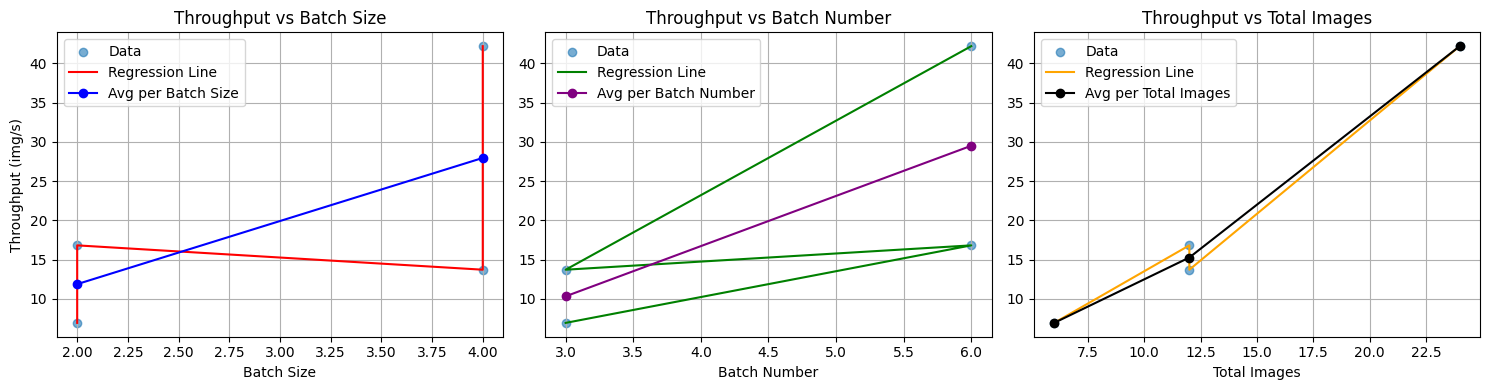

In [ ]:
import pickle
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load pickle data
!gsutil cp gs://big-data-coursework-457710-storage/results/speedtest_results_250501-1244.pkl /content/speedtest_results.pkl

with open('/content/speedtest_results.pkl', 'rb') as f:
    data = pickle.load(f)

# Prepare DataFrame
raw_results = data['raw_results']
df = pd.DataFrame(raw_results, columns=['params', 'throughput'])
df[['batch_size', 'batch_number']] = pd.DataFrame(df['params'].tolist(), index=df.index)
df.drop(columns='params', inplace=True)
df['total_images'] = df['batch_size'] * df['batch_number']
print()
print("displaying results in Table:")
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

# Linear Regression
X = df[['batch_size', 'batch_number', 'total_images']]
y = df['throughput']
model = LinearRegression().fit(X, y)

# Print coefficients
print()
print("Linear Regression Coefficients:")
# Prepare data for tabulate
coef_data = [(name, round(coef, 4)) for name, coef in zip(X.columns, model.coef_)]

# Print as a grid table
print(tabulate(coef_data, headers=["Parameter", "Coefficient"], tablefmt="grid"))
print(f"Intercept: {model.intercept_:.4f}")
print(f"R^2 Score: {model.score(X, y):.4f}")
print()

# Plotting with Averages
plt.figure(figsize=(15, 4))

# Batch Size
plt.subplot(1, 3, 1)
plt.scatter(df['batch_size'], df['throughput'], label='Data', alpha=0.6)
plt.plot(df['batch_size'], model.predict(X), color='red', label='Regression Line')

# Average line per batch_size
avg_bs = df.groupby('batch_size')['throughput'].mean().reset_index()
plt.plot(avg_bs['batch_size'], avg_bs['throughput'], marker='o', color='blue', label='Avg per Batch Size')

plt.title('Throughput vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Throughput (img/s)')
plt.grid(True)
plt.legend()

# Batch Number
plt.subplot(1, 3, 2)
plt.scatter(df['batch_number'], df['throughput'], label='Data', alpha=0.6)
plt.plot(df['batch_number'], model.predict(X), color='green', label='Regression Line')

# Average line per batch_number
avg_bn = df.groupby('batch_number')['throughput'].mean().reset_index()
plt.plot(avg_bn['batch_number'], avg_bn['throughput'], marker='o', color='purple', label='Avg per Batch Number')

plt.title('Throughput vs Batch Number')
plt.xlabel('Batch Number')
plt.grid(True)
plt.legend()

# Total Images
plt.subplot(1, 3, 3)
plt.scatter(df['total_images'], df['throughput'], label='Data', alpha=0.6)
plt.plot(df['total_images'], model.predict(X), color='orange', label='Regression Line')

# Average line per total_images
avg_prod = df.groupby('total_images')['throughput'].mean().reset_index()
plt.plot(avg_prod['total_images'], avg_prod['throughput'], marker='o', color='black', label='Avg per Total Images')

plt.title('Throughput vs Total Images')
plt.xlabel('Total Images')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket